In [3]:
#! pip install yfinance numpy matplotlib scipy

In [1]:
"""
    Code for simultating the efficient frontier 
    of the Markowitz modelling approach.
"""

import errno
import os
import signal
import functools

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

In [2]:
def portfolio_variance(x, mtx_var_covar):
    """
        Portfolio Variance Function
    """
    variance = np.matmul(np.transpose(x), np.matmul(mtx_var_covar, x))
    return variance

In [3]:
ASSETS_COUNT = 2

In [4]:
plt.style.use("ggplot")

def createweightmatrix(asset_count):
    """
        Builds a set of porfolios 
    """
    lista1 = []

    for i in range(asset_count):
        lista0 = get_weights(asset_count)
        lista1.append(lista0)
    
    dataframe1 = pd.DataFrame(
                    lista1, 
                    columns=[ f'weigth_{i}' for i in range(1, asset_count + 1)] 
                )

    return dataframe1

def get_weights(n):
    """
        Returns a vector of size n, with weights, the sum should be 1.
    """

    search_space = np.linspace(0, 1, 1_000_000)
    cumulative_weights = 0
    vector_weight = []

    for i in range(n - 1):
        weight = np.random.choice(list(search_space)) ### uniform distribution.
        vector_weight.append(weight)
        cumulative_weights = cumulative_weights + weight
        search_space = np.linspace(0, 1 - cumulative_weights, 1_000_000)

    last_weight = 1 - cumulative_weights
    vector_weight.append(last_weight)
    return vector_weight

class TimeoutError(Exception):
    """
        Custom Exception.
    """
    pass

def timeout(seconds=15, error_message=os.strerror(errno.ETIME)):
    """
        timeout decorator.
    """
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wrapper

    return decorator

def list_wikipedia_sp500() -> pd.DataFrame:
    """
        Gets stocks that compound the S&P 500 index.
    """
    # Ref: https://stackoverflow.com/a/75845569/
    url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies'
    return pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]

In [5]:
df = list_wikipedia_sp500()

symbolslist = df.index.to_list()
symbolslist.remove("BRK.B")
symbolslist.remove("BF.B")
symbolslist.remove("AES")

symbolslist

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BK',
 'BBWI',
 'BAX',
 'BDX',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BLDR',
 'BG',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CHRW',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP',
 'ED',
 '

In [6]:
symbolslist

['ABBV', 'AAPL']

In [7]:
SPInfo = yf.download(symbolslist, start = '2021-01-01')

print("Data Downloadede Successfully!")

SPPrices = SPInfo.drop(["Open","Low","Close","High", "Volume"], axis = 1).fillna(.5)
returnslog = np.log(SPPrices)
compoundedreturns = returnslog.diff()

cretunrsmean = compoundedreturns.dropna().mean(axis=0)
cretunrsmeandf = cretunrsmean.to_frame()
expectedreturn = (np.exp(cretunrsmeandf)) - 1

mweights = createweightmatrix(ASSETS_COUNT)

expectedreturn = expectedreturn.rename(
    {0: 'expected return per stock'}, 
    axis=1
)

highexreturn = expectedreturn['expected return per stock']
highexreturn = pd.DataFrame(highexreturn,columns = ['expected return per stock'])

[*********************100%%**********************]  2 of 2 completed


Data Downloadede Successfully!


In [8]:
compoundedreturns

Price      Adj Close          
Ticker          AAPL      ABBV
Date                          
2021-01-04       NaN       NaN
2021-01-05  0.012288  0.010287
2021-01-06 -0.034241 -0.008676
2021-01-07  0.033554  0.010646
2021-01-08  0.008594  0.005234
...              ...       ...
2024-04-11  0.042361 -0.008973
2024-04-12  0.008590 -0.022484
2024-04-15 -0.022106 -0.003766
2024-04-16 -0.019353  0.005367
2024-04-17 -0.008181  0.010466

[827 rows x 2 columns]

In [9]:
covreturns = compoundedreturns.cov()

In [10]:
covreturns

Price            Adj Close          
Ticker                AAPL      ABBV
Price     Ticker                    
Adj Close AAPL    0.000296  0.000034
          ABBV    0.000034  0.000169

In [20]:
expectedreturn['expected return per stock'].values

array([0.0003533 , 0.00074778])

In [10]:
x0 = [1 / len(symbolslist)] * len(symbolslist)

In [11]:
returns = np.array(highexreturn['expected return per stock'])
mtx_var_covar = np.array(covreturns)

def return_weights(target_return, notional=15):

    non_negative = [(0, None) for i in range(len(symbolslist))]

    # constraints and boundary conditions for the optimiser
    l1_norm = [{"type": "eq", "fun": lambda x: sum(abs(x)) - 1}]   # unitary in norm L2
    markowitz = [{"type": "eq", "fun": lambda x: returns.dot(x) - target_return}] 

    optimal_result = op.minimize(
        fun=portfolio_variance, 
        x0=x0,\
        args=(mtx_var_covar),\
        constraints=(l1_norm + markowitz),\
        bounds=non_negative,
        options={'maxiter': 5000}
    )
    weights = np.array(optimal_result.x)
    weights /= sum(abs(weights))
    return weights

In [28]:
expectedreturn['expected return per stock'].values

array([0.0003533 , 0.00074778])

In [68]:
returns = expectedreturn['expected return per stock'].values
min_returns = np.min(returns)
max_returns = np.max(returns)
target_returns = min_returns + np.linspace(0.05,0.95,100) * (max_returns-min_returns)

In [69]:
weights = [
    return_weights(x) for x in target_returns
]

variances = [
    portfolio_variance(weight, mtx_var_covar) for weight in weights
]

In [57]:
notional = .00001

excess_returns = [
    notional + 
    np.dot(weight, expectedreturn['expected return per stock'].values - notional) 
    for weight in weights 
]

In [77]:
symbolslist

['ABBV', 'AAPL']

/tmp/ipykernel_64810/98765642.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


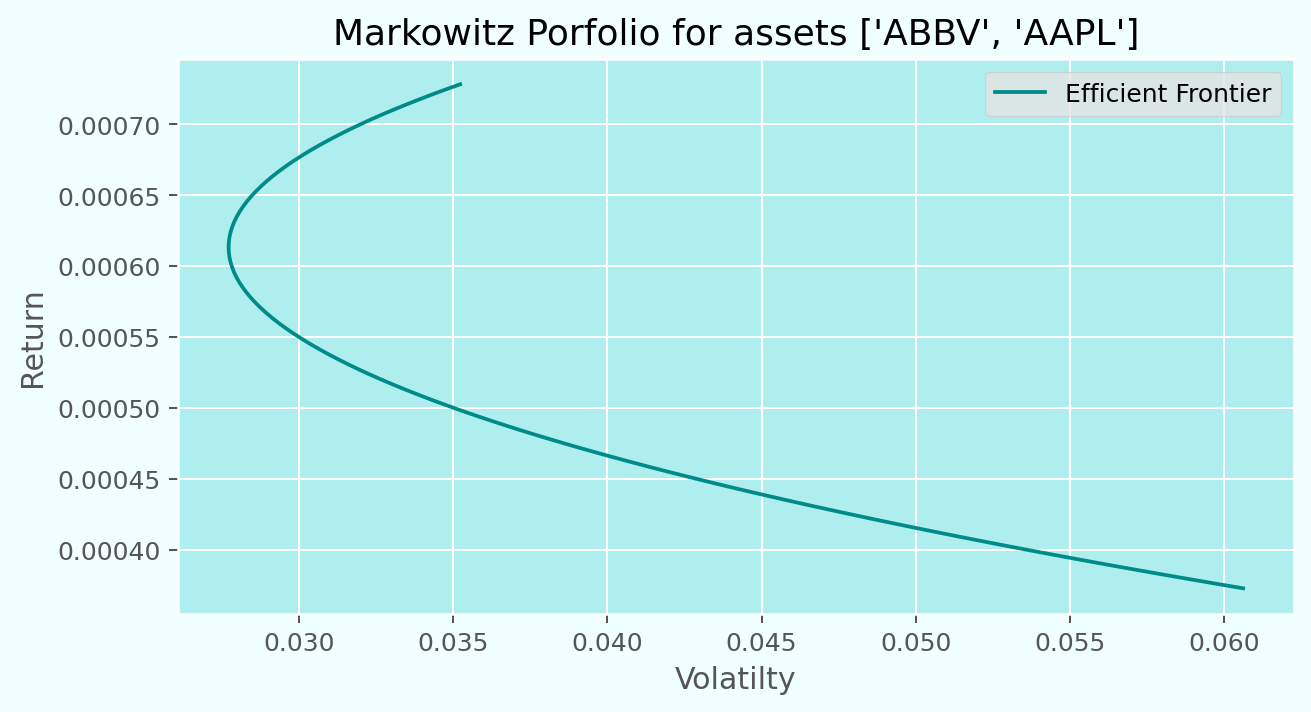

In [79]:
fig, ax = plt.subplots(
    figsize=(8, 4), dpi=180
)

ax.set_facecolor("paleturquoise")
fig.set_facecolor("azure")
ax.plot(
    variances,
    target_returns,
    label="Efficient Frontier",
    color='darkcyan'
)

ax.set_title(
    f"Markowitz Porfolio for assets {symbolslist}"
)

ax.set_xlabel(
    "Volatilty"
)


ax.set_ylabel(
    "Return"
)
ax.legend()

fig.show()